In [2]:
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, classification_report
import seaborn as sns
from IPython.display import Image  
from six import StringIO  
import pydot

In [3]:
# Number of QPSK symbols to be transmitted.
N = 10000

seed = 1234

In [13]:
# Definition of several utility functions.
def mod(V):
    ip = np.zeros((len(V),1),dtype=complex)
    inc = 0
    for v in V:
        if(v==0):
            ip[inc] = -1.0 - 1j*1.0
        elif(v==1):
            ip[inc] = -1.0 + 1j*1.0
        elif(v==2):
            ip[inc] = 1.0 - 1j*1.0
        else:
            ip[inc] = 1.0 + 1j*1.0
        inc += 1
    # Normalization of energy to 1.
    s = (1/np.sqrt(2))*ip;
    return s

def demod(c):
    c_seq = mod(np.array([0,1,2,3]))
    c_seq = c_seq[:,0]
    e = []
    for i in range(0,len(c_seq)):
        e.append(np.abs(c_seq[i] - c)**2)
    return e.index(np.min(e))

def toOneHotEncoding(V):
    bits = np.zeros((len(V),4))
    for i in range(0,len(V)):
        if(V[i]==0):
            bits[i,:] = np.array([1,0,0,0])
        elif(V[i]==1):
            bits[i,:] = np.array([0,1,0,0])
        elif(V[i]==2):
            bits[i,:] = np.array([0,0,1,0])
        else:
            bits[i,:] = np.array([0,0,0,1])
    return bits
    
def fromOneHotEncoding(bits):
    v = np.argmax(bits, axis=0)
    return v

def optimumDemod(y):
    d = np.zeros((len(y),))
    for i in range(0,len(y)):
        if(y[i, 0] >= 0 and y[i, 1] >= 0):
            d[i] = 3
        elif(y[i, 0] < 0 and y[i, 1] >= 0):
            d[i] = 1
        elif(y[i, 0] < 0 and y[i, 1] < 0):
            d[i] = 0
        elif(y[i, 0] >= 0 and y[i, 1] < 0):
            d[i] = 2
        else:
            print('Error....')
    return d

def detection(clf, XY, isMLP):
    if(isMLP==False):
        ZZ = clf.predict(XY)
        Z = np.zeros((len(ZZ),))
        for i in range(0,len(Z)):
            Z[i] = fromOneHotEncoding(ZZ[i,:])
    else:
        Z = optimumDemod(XY)
    return Z

def plotDecisionBoundaries(Y, clf, b_train, SER, titleStr):
    # Step size in the mesh.
    h = .02 

    plt.figure(figsize=(15, 5))
    # Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = Y[:, 0].min() - 1, Y[:, 0].max() + 1
    y_min, y_max = Y[:, 1].min() - 1, Y[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    XY = np.c_[xx.ravel(), yy.ravel()]
    
    for i in range(0,2):
        ax = plt.subplot(1, 2, i + 1)
    
        Z = detection(clf, XY, i)
        # Put the result into a color plot.
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, shading='auto')

        # Plot also the training points.
        plt.scatter(Y[:, 0], Y[:, 1], c=b_train.ravel(), edgecolor='k', s=30)
        plt.xlim(-2.0, 2.0)
        plt.ylim(-2.0, 2.0)
        plt.xlabel('In-Phase', fontsize=14)
        plt.ylabel('Quadrature', fontsize=14)
        plt.title(titleStr[i]+' - SER: '+str(SER[i]))
    
    plt.savefig('qpsk_detection.png', dpi=600)
    plt.show()

In [14]:
# Modulation

np.random.seed(seed)
# Generate N binary symbols.
bits = np.random.randint(0,4,(N,1))    
# Modulate the binary stream into QPSK symbols.
s = mod(bits)

In [15]:
# AWGN Channel

# Generate noise vector. 
# Divide by two once the theoretical ber uses a complex Normal pdf with variance of each part = 1/2.
np.random.seed(seed)
noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))    
# Pass symbols through AWGN channel.
y = s + np.sqrt(0.2)*noise

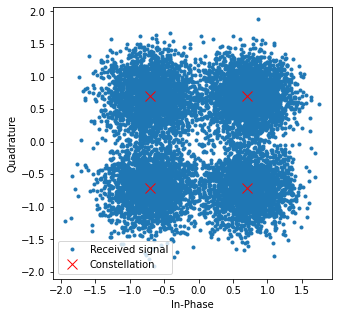

In [16]:
constellation = mod(np.array([0,1,2,3]))
plt.figure(figsize=(5,5))
plt.plot(y.real, y.imag, '.', label='Received signal')
plt.plot(constellation.real, constellation.imag, 'rx', markersize=10, label='Constellation')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.legend()
plt.savefig('constellation.png', dpi=600)
plt.show()

In [17]:
# Demodulation

# Instantiate Multi layer Perceptron Classifier. (10,4) (4,2)
clf = MLPClassifier(hidden_layer_sizes=(10,4), activation='logistic', solver='sgd', batch_size=50, learning_rate='adaptive', random_state=seed, max_iter=4000)
# Split arrays into random train and test subsets.
s_test, s_train, y_test, y_train, b_test, b_train = train_test_split(s, y, bits, random_state=seed)
# SciKit-learn's MLPs do not support complex signals, then we split the received vector into a matrix with two attributes, x1 and x2.
Y = np.c_[y_train.real,y_train.imag]
# Fit the MLP model.
clf.fit(Y, toOneHotEncoding(b_train))
# Prediction (detection) with trained MLP.
detected_mlp = clf.predict(np.c_[y_test.real, y_test.imag])
# Detection with optimum detector.
detected_opt = optimumDemod(np.c_[y_test.real, y_test.imag])

In [18]:
# Calculate QPSK BER with MLP detector.
error = 0
for i in range(0, len(b_test)):
    if((b_test[i,0] != fromOneHotEncoding(detected_mlp[i,:]) )==True): 
        error = error + 1
    
ser_simu_mlp = 1.0 * error / len(b_test)

print('MLP SER: ', ser_simu_mlp)

# Calculate QPSK BER with optimum detector.
error = 0
for i in range(0, len(b_test)):
    if((b_test[i,0] != detected_opt[i] )==True): 
        error = error + 1
    
ser_simu_opt = 1.0 * error / len(b_test)
    
print('OPT SER: ',ser_simu_opt)

MLP SER:  0.025466666666666665
OPT SER:  0.025333333333333333


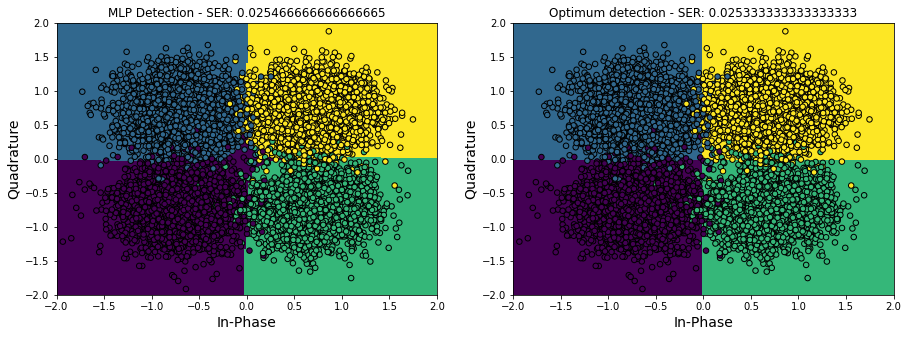

In [19]:
titleStr = ['MLP Detection', 'Optimum detection']
SER = [ser_simu_mlp, ser_simu_opt]
Y = np.c_[y.real, y.imag]
plotDecisionBoundaries(Y, clf, bits, SER, titleStr)